## **FINAL PIPELINE: Punctuation score+RF, TFIDF+RF, Perplexity, Roberta based detector and classifier on the top**

In [1]:
import os 
print(os.getcwd())
os.chdir('../..')
print(os.getcwd())

/home/onyxia/work/ml-for-nlp/analysis/notebooks
/home/onyxia/work/ml-for-nlp


In [2]:
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
import seaborn as sns


/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from src.libs.preprocess_dataframe_train_test import load_all_datasets
from src.pipeline.whole_pipeline import punctuation_map_dimensions_to_names, punctuation_transform, punctuation_map_dimensions_to_names, fit_tfidf_embedding, transform_with_tfidf, train_fine_tune_RF, eval_model, eval_model_binary, evaluate, get_oof_predictions, get_oof_predictions_tfidf

In [4]:
### LOAD DATA

data = load_all_datasets()

### Global X, y
X_train = data["X_train"]
y_train = (data["y_train"]>0).astype(int)
X_test = data["X_test"]
y_test = (data["y_test"]>0).astype(int)

### Global dataframes
df_train = data["df_train"]
df_test = data["df_test"]

### By type: poetry, essay, story (train)
df_train_poetry = data["df_train_poetry"]
df_train_essay = data["df_train_essay"]
df_train_story = data["df_train_story"]
X_train_poetry = data["X_train_poetry"]
y_train_poetry = (data["y_train_poetry"]>0).astype(int)
X_train_essay = data["X_train_essay"]
y_train_essay = (data["y_train_essay"]>0).astype(int)
X_train_story = data["X_train_story"]
y_train_story = (data["y_train_story"]>0).astype(int)

### By type: poetry, essay, story (test)
df_test_poetry = data["df_test_poetry"]
df_test_essay = data["df_test_essay"]
df_test_story = data["df_test_story"]
X_test_poetry = data["X_test_poetry"]
y_test_poetry = (data["y_test_poetry"]>0).astype(int)
X_test_essay = data["X_test_essay"]
y_test_essay = (data["y_test_essay"]>0).astype(int)
X_test_story = data["X_test_story"]
y_test_story = (data["y_test_story"]>0).astype(int)

Time taken to load dataset: 0.02644062042236328 seconds
Time taken to load dataset: 0.015386104583740234 seconds
Time taken to load dataset: 0.5906002521514893 seconds
Time taken to load dataset: 0.02279496192932129 seconds
Time taken to load dataset: 0.016936540603637695 seconds
Time taken to load dataset: 0.14981818199157715 seconds
Time taken to load dataset: 0.029948711395263672 seconds
Time taken to load dataset: 0.01854538917541504 seconds
Time taken to load dataset: 0.02794623374938965 seconds


### **PUNCTUATION**

In [5]:
### EMBEDDING

X_train_punct = punctuation_transform(X_train)
X_test_punct = punctuation_transform(X_test)
X_test_poetry_punct = punctuation_transform(X_test_poetry)
X_test_essay_punct = punctuation_transform(X_test_essay)
X_test_story_punct = punctuation_transform(X_test_story)

In [6]:
### GET score train with CV out of fold
y_proba_train = get_oof_predictions(X_train_punct, y_train, train_fine_tune_RF)

Fold 1/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 173}
Fold 2/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 173}
Fold 3/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': 11, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 111}
Fold 4/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 239}
Fold 5/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': 14, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 239}


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': False, 'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 239}


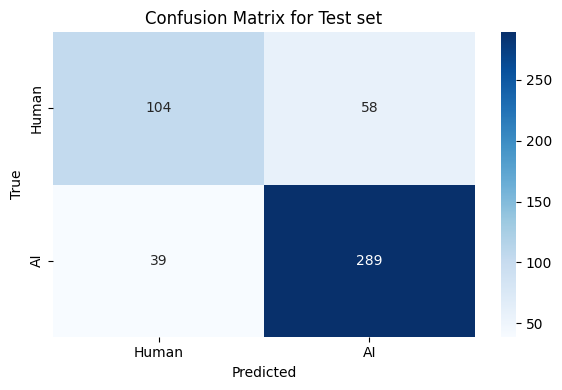

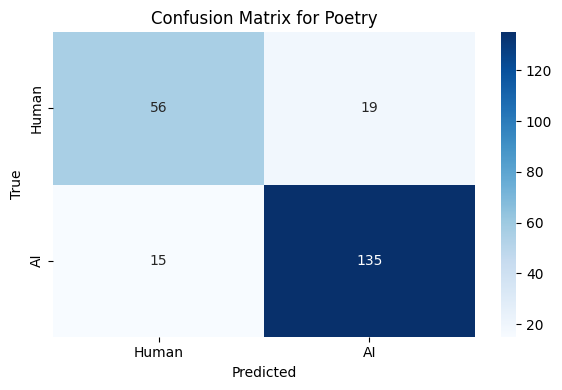

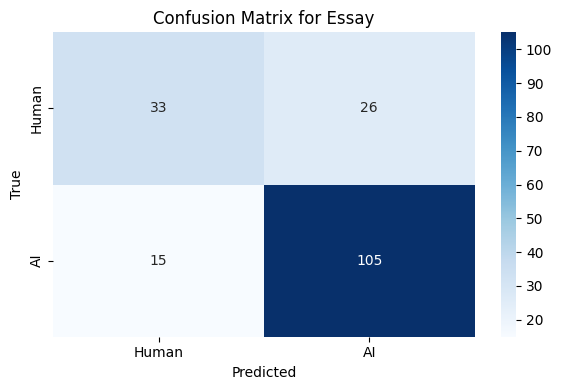

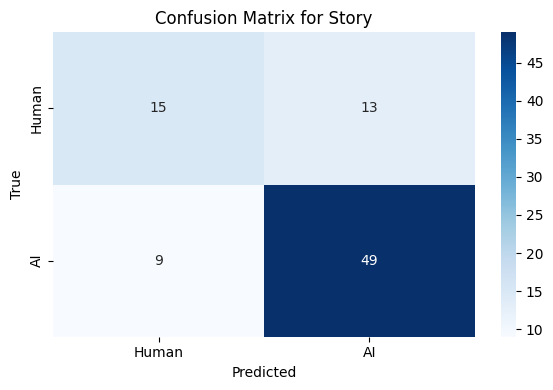

              confusion_matrix precision    recall        f1
test    [[104, 58], [39, 289]]  0.780063  0.761536  0.769132
poetry   [[56, 19], [15, 135]]  0.832678  0.823333  0.827641
essay    [[33, 26], [15, 105]]  0.744513  0.717161  0.726738
story      [[15, 13], [9, 49]]  0.707661  0.690271  0.696795


In [7]:
classifier_punct = train_fine_tune_RF(X_train_punct, y_train)
eval_model_binary(classifier_punct, X_train_punct, y_train, X_test_punct, y_test, X_test_poetry_punct, y_test_poetry, X_test_essay_punct, y_test_essay, X_test_story_punct, y_test_story)
y_proba_test = classifier_punct.predict_proba(X_test_punct)[:, 1]

In [8]:
df_train["punctuation_score"] = y_proba_train
df_test["punctuation_score"] = y_proba_test

### **TF-IDF**

In [9]:
### TF-IDF embedding
vectorizer_tfidf, X_train_tfidf = fit_tfidf_embedding(X_train, max_features=1000)

X_test_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test)
X_test_poetry_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_poetry)
X_test_essay_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_essay)
X_test_story_tfidf = transform_with_tfidf(vectorizer_tfidf, X_test_story)

In [10]:
### GET score train with CV out of fold
y_proba_train = get_oof_predictions_tfidf(X_train_tfidf, y_train, train_fine_tune_RF)

Fold 1/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits


Best hyperparameters: {'bootstrap': True, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 173}
Fold 2/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 173}
Fold 3/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 173}
Fold 4/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 173}
Fold 5/5
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 173}


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 173}


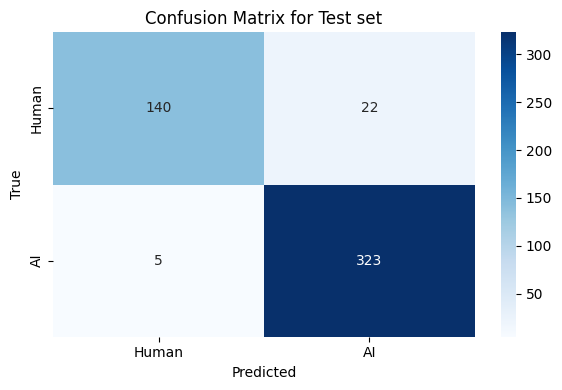

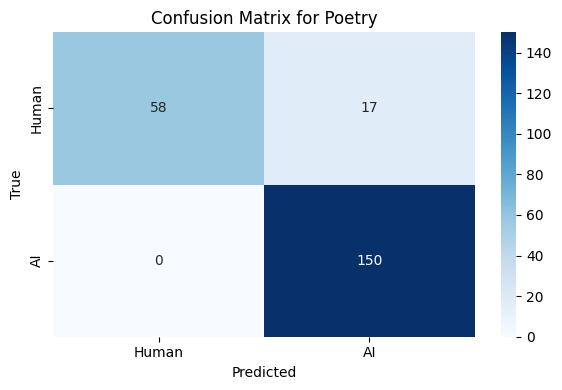

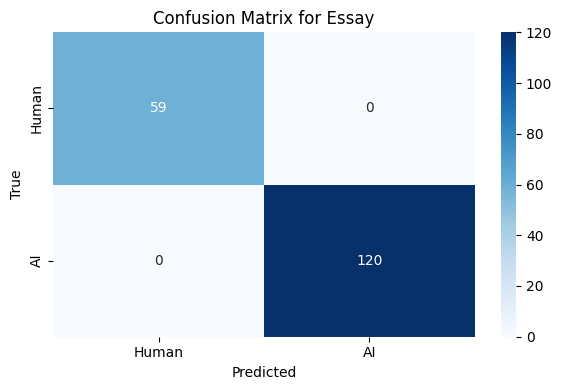

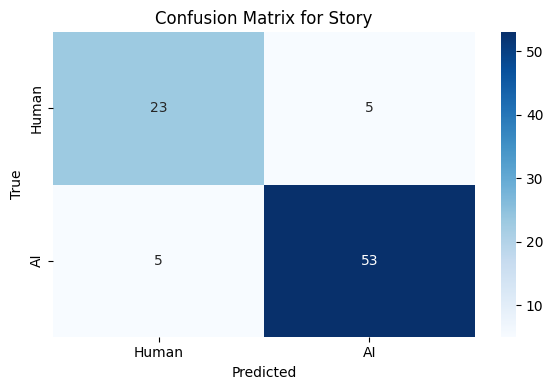

             confusion_matrix precision    recall        f1
test    [[140, 22], [5, 323]]  0.950875  0.924477  0.935967
poetry   [[58, 17], [0, 150]]  0.949102  0.886667  0.909276
essay     [[59, 0], [0, 120]]       1.0       1.0       1.0
story      [[23, 5], [5, 53]]  0.867611  0.867611  0.867611


In [11]:
classifier_tfidf = train_fine_tune_RF(X_train_tfidf, y_train)
eval_model_binary(classifier_tfidf, X_train_tfidf, y_train, X_test_tfidf, y_test, X_test_poetry_tfidf, y_test_poetry, X_test_essay_tfidf, y_test_essay, X_test_story_tfidf, y_test_story)
y_proba_test = classifier_tfidf.predict_proba(X_test_tfidf)[:, 1]

In [12]:
df_train["tfidf_score"] = y_proba_train
df_test["tfidf_score"] = y_proba_test

### **PERPLEXITY**

In [13]:
### Load pretrained model

tqdm.pandas()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "distilgpt2" 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [14]:
def compute_perplexity(text):
    """Calcule la perplexité d'un texte avec un modèle de langage causal"""
    try:
        encodings = tokenizer(text, return_tensors="pt", truncation=True, max_length=1024)
        input_ids = encodings["input_ids"].to(device)
        with torch.no_grad():
            outputs = model(input_ids, labels=input_ids)
            loss = outputs.loss
        return torch.exp(loss).item()
    except Exception as e:
        print(f"Erreur pour le texte : {text[:50]}... -> {e}")
        return None

In [15]:
tqdm.pandas()
df_train["perplexity"] = df_train["text"].progress_apply(compute_perplexity)
df_test["perplexity"] = df_test["text"].progress_apply(compute_perplexity)

  0%|          | 0/1139 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.
100%|██████████| 490/490 [00:14<00:00, 33.87it/s]


### **ROBERTA**

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_id = "roberta-base-openai-detector"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id).to(device)
model.eval() 

Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [17]:
def detect_score(text):
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            logits = model(**inputs).logits
            probs = softmax(logits, dim=1)
        return probs[0][1].item() 
    except Exception as e:
        print(f"Erreur avec le texte : {e}")
        return None

In [18]:
tqdm.pandas()

df_train["llm_score"] = df_train["text"].progress_apply(detect_score)
df_test["llm_score"] = df_test["text"].progress_apply(detect_score)

  0%|          | 0/1139 [00:00<?, ?it/s]

100%|██████████| 490/490 [00:15<00:00, 32.36it/s]


## **META CLASSIFIER : BINARY**

In [19]:
X_train_score, y_train = df_train[["punctuation_score",'tfidf_score',"perplexity","llm_score"]].copy(), (df_train[["label"]]>0).astype(int).copy().values.ravel()
X_test_score, y_test = df_test[["punctuation_score",'tfidf_score',"perplexity","llm_score"]].copy(), (df_test[["label"]]>0).astype(int).copy().values.ravel()
X_test_poetry_score, y_test_poetry = df_test[df_test.type=="poetry"][["punctuation_score",'tfidf_score',"perplexity","llm_score"]].copy(), (df_test[df_test.type=="poetry"][["label"]]>0).astype(int).copy().values.ravel()
X_test_story_score, y_test_story = df_test[df_test.type=="story"][["punctuation_score",'tfidf_score',"perplexity","llm_score"]].copy(), (df_test[df_test.type=="story"][["label"]]>0).astype(int).copy().values.ravel()
X_test_essay_score, y_test_essay = df_test[df_test.type=="essay"][["punctuation_score",'tfidf_score',"perplexity","llm_score"]].copy(), (df_test[df_test.type=="essay"][["label"]]>0).astype(int).copy().values.ravel()

In [27]:
meta_classifier = train_fine_tune_RF(X_train_score, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


Best hyperparameters: {'bootstrap': True, 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 170}


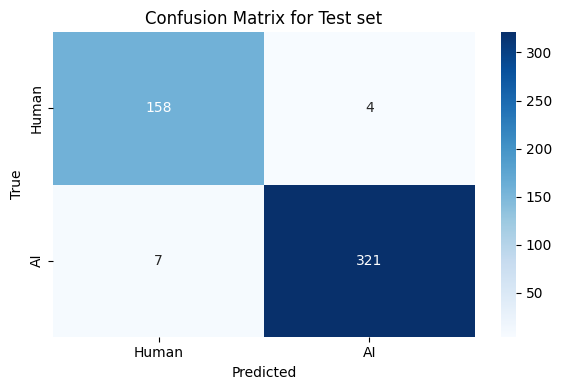

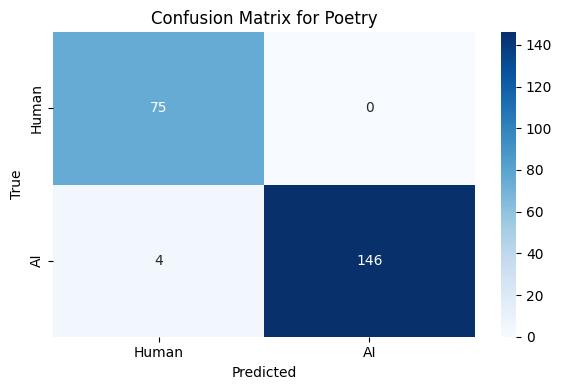

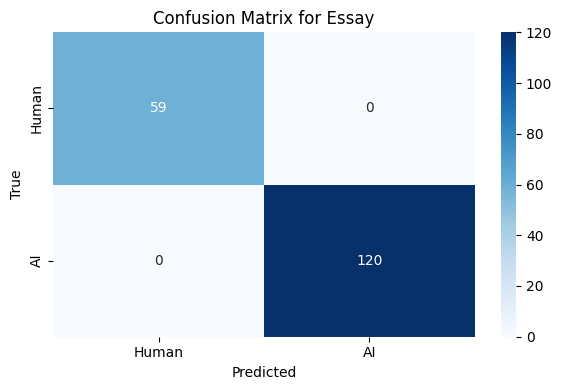

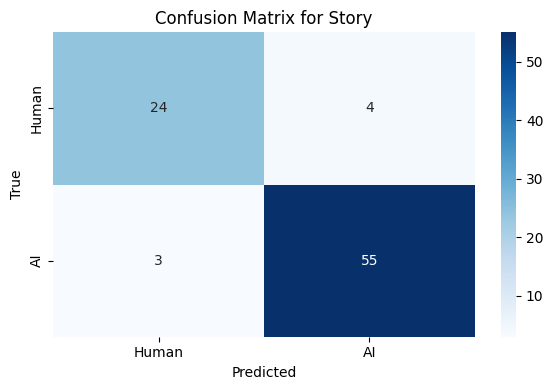

            confusion_matrix precision    recall        f1
test    [[158, 4], [7, 321]]  0.972634  0.976984  0.974758
poetry   [[75, 0], [4, 146]]  0.974684  0.986667  0.980256
essay    [[59, 0], [0, 120]]       1.0       1.0       1.0
story     [[24, 4], [3, 55]]  0.910546  0.902709  0.906449


RandomForestClassifier(max_depth=9, n_estimators=170, n_jobs=-1,
                       random_state=42)

In [28]:
eval_model_binary(
    meta_classifier,
    X_train_score, y_train,
    X_test_score, y_test,
    X_test_poetry_score, y_test_poetry,
    X_test_essay_score, y_test_essay,
    X_test_story_score, y_test_story
)

### **FEATURE IMPORTANCE**

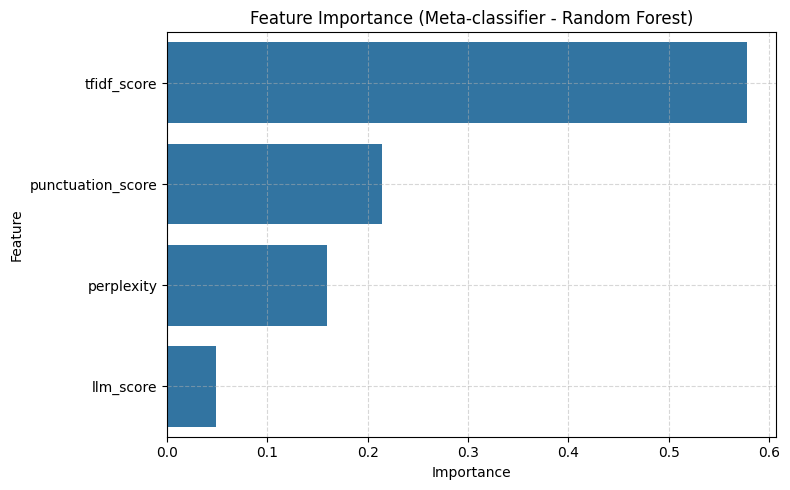

In [29]:
feature_names = ["punctuation_score", "tfidf_score", "perplexity", "llm_score"]
importances = meta_classifier.feature_importances_

sorted_indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in sorted_indices]
sorted_importances = importances[sorted_indices]

plt.figure(figsize=(8, 5))
sns.barplot(x=sorted_importances, y=sorted_features)
plt.title("Feature Importance (Meta-classifier - Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# **INFERENCE**

In [31]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import math 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the GPT-2 model for computing perplexity
perplexity_model_name = "distilgpt2"
perplexity_tokenizer = AutoTokenizer.from_pretrained(perplexity_model_name)
perplexity_model = AutoModelForCausalLM.from_pretrained(perplexity_model_name).to(device)
perplexity_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the GPT-2 model for computing perplexity
perplexity_model_name = "distilgpt2"
perplexity_tokenizer = AutoTokenizer.from_pretrained(perplexity_model_name)
perplexity_model = AutoModelForCausalLM.from_pretrained(perplexity_model_name).to(device)
perplexity_model.eval()


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [32]:
def inference_binary(
    text,
    classifier_punct,
    punctuation_transform,
    classifier_tfidf,
    vectorizer_tfidf,
    perplexity_model,             # GPT-2 model for perplexity
    perplexity_tokenizer,         # tokenizer for GPT-2
    detect_score,                 # Roberta-based AI score function (already loaded model inside)
    meta_classifier
):
    # ----- Punctuation -----
    punct_vec = punctuation_transform(text)
    y_proba_punct = classifier_punct.predict_proba(punct_vec)[:, 1][0]

    # ----- TF-IDF -----
    tfidf_vec = transform_with_tfidf(vectorizer_tfidf,text)
    y_proba_tfidf = classifier_tfidf.predict_proba(tfidf_vec)[:, 1][0]

    # ----- Perplexity -----
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_name = "distilgpt2" 
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
    model.eval()
    def compute_perplexity(text):
        try:
            inputs = perplexity_tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
            input_ids = inputs["input_ids"].to(perplexity_model.device)
            with torch.no_grad():
                outputs = perplexity_model(input_ids=input_ids, labels=input_ids)
                loss = outputs.loss
            return math.exp(loss.item())
        except Exception as e:
            print(f"Erreur perplexité : {e}")
            return float("inf")

    perplexity = compute_perplexity(text)

    # ----- Roberta detector -----
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_id = "roberta-base-openai-detector"
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id).to(device)
    model.eval() 
    llm_score = detect_score(text)

    # ----- Meta-classifier -----
    X_meta = np.array([[y_proba_punct, y_proba_tfidf, perplexity, llm_score]])
    print("X_meta =", X_meta)

    proba = meta_classifier.predict_proba(X_meta)[0]
    pred_class = meta_classifier.predict(X_meta)[0]
    print(meta_classifier.predict(X_meta))
    print("Classes meta:", meta_classifier.classes_)


    label_map = {0: "HUMAN", 1: "AI-GENERATED"}
    label = label_map.get(pred_class, "UNKNOWN")

    # ----- Output -----
    print(f"\n--- Binary Prediction ---")
    print(f"Punctuation model: proba = {y_proba_punct:.4f}")
    print(f"TF-IDF model:      proba = {y_proba_tfidf:.4f}")
    print(f"Perplexity:                               {perplexity:.2f}")
    print(f"Roberta detector (AI proba):             {llm_score:.4f}")
    print(f"\nMeta prediction: {label}  (proba = {proba[pred_class]:.4f})")

    return label, proba


## **TEST WITH CHATGPT 4o**
We use the following prompt: 
> Give me two poems: one that feels like it was written by a human, and one that feels like it was generated by an AI.

In [33]:
human_like_poem = ["""
A Morning Without Reason

I woke up, not sure why—  
The sky was gray, but not quite sad.  
There might have been wind, or maybe not,  
A breath perhaps, or just a thought.

I looked at the wall, the cup, the chair,  
Things that don’t move but somehow speak.  
A silence, worn and a little rough,  
Clung softly to the edge of the window.

And I did nothing. But it felt okay.  
As if the moment had forgotten the rest.  
No goal, no sound, no proper light—  
Yet something quietly... existed.
"""]

inference_binary(
    human_like_poem,
    classifier_punct,
    punctuation_transform,
    classifier_tfidf,
    vectorizer_tfidf,
    perplexity_model,             
    perplexity_tokenizer,         
    detect_score,                
    meta_classifier
)

Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


X_meta = [[ 0.07149831  0.41419954 38.05923285  0.63387376]]


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[0]
Classes meta: [0 1]

--- Binary Prediction ---
Punctuation model: proba = 0.0715
TF-IDF model:      proba = 0.4142
Perplexity:                               38.06
Roberta detector (AI proba):             0.6339

Meta prediction: HUMAN  (proba = 0.9639)


('HUMAN', array([0.96392138, 0.03607862]))

In [34]:
ai_like_poem = ["""
Reflections at Dawn

The morning breaks with gentle light,  
A sky of gold, a world made bright.  
The air is still, the silence deep,  
A perfect calm, as if in sleep.

The coffee steams, the pages turn,  
Soft patterns in the shadows burn.  
Each moment flows, precise and clear,  
With nothing lost, and nothing near.

A sense of peace, a steady breath,  
No fear of time, no thought of death.  
Just ordered steps the day shall take,  
Until the stars again awake.
"""
]

inference_binary(
    ai_like_poem,
    classifier_punct,
    punctuation_transform,
    classifier_tfidf,
    vectorizer_tfidf,
    perplexity_model,             
    perplexity_tokenizer,         
    detect_score,                
    meta_classifier
)

Some weights of the model checkpoint at roberta-base-openai-detector were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


X_meta = [[ 0.96050147  0.63524979 57.38077518  0.99857628]]


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[1]
Classes meta: [0 1]

--- Binary Prediction ---
Punctuation model: proba = 0.9605
TF-IDF model:      proba = 0.6352
Perplexity:                               57.38
Roberta detector (AI proba):             0.9986

Meta prediction: AI-GENERATED  (proba = 0.9765)


('AI-GENERATED', array([0.02352941, 0.97647059]))